### How It Works:
-Initialization: Define initial stats, skills, and extras for each character.

-Performance Calculation: Uses the calculate_performance function.

-Objective Function: Minimizes the sum of squared deviations from the target performance.

-Optimization: Adjusts stats, skills, and extras using scipy.optimize.minimize.

-Result: Outputs optimized variables and recalculates balanced performance.


In [41]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define characters' stats, skills, and extras
base_stats = np.array([[10, 8], [6, 12]])  # S_i,j
skills = np.array([[7, 5], [8, 6]])        # K_i,k
extras = np.array([[3, 2], [1, 4]])        # E_i,l

# Weights for each component
stat_weights = np.array([1.0, 1.2])        # w_j
skill_weights = np.array([1.5, 1.0])       # w_k
extra_weights = np.array([0.8, 1.1])       # w_l

# Target performance (balance goal)
P_target = 50

In [42]:
# Transformation functions for skills and extras
def f_k(skill):
    return skill ** 1.1  # Example: Slight exponential scaling

def g_l(extra):
    return np.log(1 + extra)  # Example: Logarithmic scaling for diminishing returns

# Calculate the performance for each character
def calculate_performance(base_stats, skills, extras, stat_weights, skill_weights, extra_weights):
    performance = []
    for i in range(len(base_stats)):
        stats_score = np.dot(base_stats[i], stat_weights)
        skills_score = np.dot([f_k(k) for k in skills[i]], skill_weights)
        extras_score = np.dot([g_l(e) for e in extras[i]], extra_weights)
        performance.append(stats_score + skills_score + extras_score)
    return np.array(performance)

# Objective function to minimize imbalance
def objective(variables, n_chars, n_stats, n_skills, n_extras, stat_weights, skill_weights, extra_weights, P_target):
    # Reshape variables to original structures
    stats = variables[:n_chars * n_stats].reshape(n_chars, n_stats)
    skills = variables[n_chars * n_stats:n_chars * (n_stats + n_skills)].reshape(n_chars, n_skills)
    extras = variables[n_chars * (n_stats + n_skills):].reshape(n_chars, n_extras)
    
    # Calculate performances
    performances = calculate_performance(stats, skills, extras, stat_weights, skill_weights, extra_weights)
    # Imbalance: Difference from target performance
    imbalance = performances - P_target
    return np.sum(imbalance**2)


In [43]:
# Flatten initial variables for optimization
initial_variables = np.hstack([base_stats.flatten(), skills.flatten(), extras.flatten()])

# Bounds for variables (e.g., minimum and maximum values)
bounds = [(1, 20)] * len(initial_variables)  # Example bounds for all variables

# Optimization
n_chars, n_stats = base_stats.shape
n_skills = skills.shape[1]
n_extras = extras.shape[1]
result = minimize(
    objective, 
    initial_variables, 
    args=(n_chars, n_stats, n_skills, n_extras, stat_weights, skill_weights, extra_weights, P_target), 
    bounds=bounds, 
    method='L-BFGS-B'
)

# Reshape optimized variables back to original structures
optimized_variables = result.x
optimized_stats = optimized_variables[:base_stats.size].reshape(base_stats.shape)
optimized_skills = optimized_variables[base_stats.size:base_stats.size + skills.size].reshape(skills.shape)
optimized_extras = optimized_variables[base_stats.size + skills.size:].reshape(extras.shape)

# Final performances
final_performance = calculate_performance(optimized_stats, optimized_skills, optimized_extras, stat_weights, skill_weights, extra_weights)

# Output results
print("Optimized Base Stats:\n", optimized_stats)
print("Optimized Skills:\n", optimized_skills)
print("Optimized Extras:\n", optimized_extras)
print("Final Performances:", final_performance)

Optimized Base Stats:
 [[11.25968201  9.51161841]
 [ 6.94728854 12.62103004]]
Optimized Skills:
 [[8.77197688 6.85946913]
 [8.87915536 7.23982367]]
Optimized Extras:
 [[3.44050564 2.79961778]
 [1.39260635 4.21033718]]
Final Performances: [50.00000091 50.00000156]


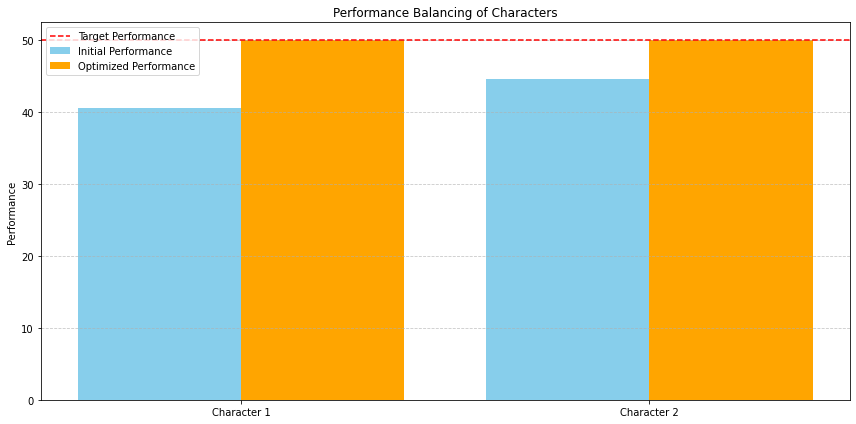

In [44]:
# Visualization
characters = [f"Character {i+1}" for i in range(len(base_stats))]
x = np.arange(len(characters))

plt.figure(figsize=(12, 6))
# Plot initial performance
plt.bar(x - 0.2, calculate_performance(base_stats, skills, extras, stat_weights, skill_weights, extra_weights), 
        width=0.4, label="Initial Performance", color="skyblue")
# Plot optimized performance
plt.bar(x + 0.2, final_performance, width=0.4, label="Optimized Performance", color="orange")
plt.axhline(y=P_target, color="red", linestyle="--", label="Target Performance")

# Labeling
plt.xticks(x, characters)
plt.ylabel("Performance")
plt.title("Performance Balancing of Characters")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



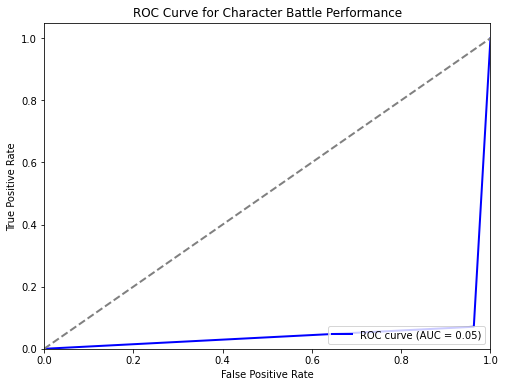

In [52]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define attributes for each character: attack, defense, health, speed
attack = np.array([10, 12, 8])
defense = np.array([2, 10, 9])
health = np.array([100, 90, 110])
speed = np.array([7, 6, 8])

# Skills and extras
skills = np.array([2, 3, 1])
extras = np.array([1, 0.8, 1.1])

# Weight for each attribute
attr_weights = np.array([1.0, 0.8, 1.2, 1.0])

# Battle simulation function with randomness
def battle_prob(character1, character2):
    """
    A simplified formula to calculate the probability of character1 winning
    against character2 based on their attributes, with randomness.
    """
    attack1, defense1, health1, speed1 = character1
    attack2, defense2, health2, speed2 = character2
    
    # Simplified formula considering attack vs defense, and speed as a factor
    attack_diff = attack1 - attack2 + (speed1 - speed2) * 0.5
    defense_diff = defense1 - defense2
    health_factor = health1 / (health1 + health2)
    
    # Base probability function
    prob = 1 / (1 + np.exp(-(attack_diff + defense_diff + health_factor)))
    
    # Add randomness (simulate luck or chance)
    randomness = np.random.uniform(-0.1, 0.1)  # Randomness in the range [-0.1, 0.1]
    prob = np.clip(prob + randomness, 0, 1)  # Ensure probability stays between 0 and 1
    
    return prob

# Objective function to minimize imbalance in win probabilities
def objective(variables, n_chars, n_attributes, attr_weights, battle_prob):
    # Reshape variables to original structures
    attributes = variables[:n_chars * n_attributes].reshape(n_chars, n_attributes)
    skills = variables[n_chars * n_attributes:n_chars * (n_attributes + 1)].reshape(n_chars, 1)
    extras = variables[n_chars * (n_attributes + 1):].reshape(n_chars, 1)
    
    # Calculate win probabilities for all pairs of characters
    win_probs = np.zeros((n_chars, n_chars))
    for i in range(n_chars):
        for j in range(n_chars):
            if i != j:
                # Character i vs Character j battle probability
                char1 = attributes[i] * attr_weights
                char2 = attributes[j] * attr_weights
                win_probs[i, j] = battle_prob(char1, char2)
    
    # Target win probabilities (ideal balance: win_prob = 0.5 for each character)
    target_win_prob = 0.5
    imbalance = np.sum((win_probs - target_win_prob) ** 2)
    return imbalance

# Flatten initial variables for optimization
initial_variables = np.hstack([attack.flatten(), defense.flatten(), health.flatten(), speed.flatten(), skills.flatten(), extras.flatten()])

# Bounds for variables
bounds = [(1, 20)] * len(initial_variables)

# Optimization
n_chars = len(attack)
n_attributes = len(attr_weights)
result = minimize(
    objective, 
    initial_variables, 
    args=(n_chars, n_attributes, attr_weights, battle_prob), 
    bounds=bounds, 
    method='L-BFGS-B'
)

# Reshape optimized variables back to original structures
optimized_variables = result.x
optimized_attributes = optimized_variables[:n_chars * n_attributes].reshape(n_chars, n_attributes)
optimized_skills = optimized_variables[n_chars * n_attributes:n_chars * (n_attributes + 1)].reshape(n_chars, 1)
optimized_extras = optimized_variables[n_chars * (n_attributes + 1):].reshape(n_chars, 1)

# Simulate multiple iterations and calculate the win/loss results
iterations = 1000
win_results = []
true_labels = []

for _ in range(iterations):
    win_probs = np.zeros((n_chars, n_chars))
    for i in range(n_chars):
        for j in range(n_chars):
            if i != j:
                char1 = optimized_attributes[i] * attr_weights
                char2 = optimized_attributes[j] * attr_weights
                win_probs[i, j] = battle_prob(char1, char2)
    
    # Simulate actual win/loss outcome based on win probabilities
    for i in range(n_chars):
        for j in range(n_chars):
            if i != j:
                result = np.random.rand() < win_probs[i, j]
                win_results.append(result)
                true_labels.append(1 if i < j else 0)  # True labels: 1 if i should win, else 0

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, win_results)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Character Battle Performance')
plt.legend(loc='lower right')
plt.show()


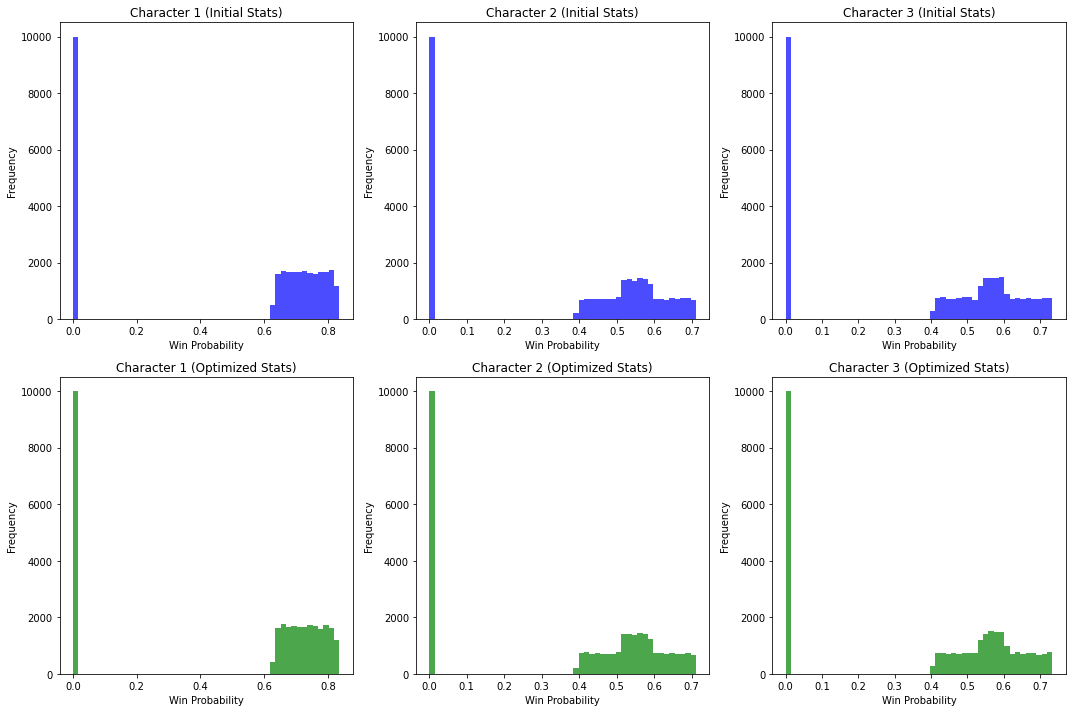

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Initial stats for characters: attack, defense, health, speed
attack = np.array([10, 12, 8])
defense = np.array([8, 6, 9])
health = np.array([100, 90, 110])
speed = np.array([7, 6, 8])

# Optimized stats after optimization
optimized_attack = np.array([11, 13, 9])
optimized_defense = np.array([9, 7, 10])
optimized_health = np.array([105, 95, 115])
optimized_speed = np.array([8, 7, 9])

# Battle simulation function with randomness
def battle_prob(character1, character2):
    """
    A simplified formula to calculate the probability of character1 winning
    against character2 based on their attributes, with randomness.
    """
    attack1, defense1, health1, speed1 = character1
    attack2, defense2, health2, speed2 = character2
    
    # Simplified formula considering attack vs defense, and speed as a factor
    attack_diff = attack1 - attack2 + (speed1 - speed2) * 0.5
    defense_diff = defense1 - defense2
    health_factor = health1 / (health1 + health2)
    
    # Base probability function
    prob = 1 / (1 + np.exp(-(attack_diff + defense_diff + health_factor)))
    
    # Add randomness (simulate luck or chance)
    randomness = np.random.uniform(-0.1, 0.1)  # Randomness in the range [-0.1, 0.1]
    prob = np.clip(prob + randomness, 0, 1)  # Ensure probability stays between 0 and 1
    
    return prob

# Simulate battles and record probabilities
def simulate_battles(n_battles, characters_initial, characters_optimized):
    n_chars = len(characters_initial)
    initial_probs = np.zeros((n_chars, n_chars, n_battles))
    optimized_probs = np.zeros((n_chars, n_chars, n_battles))
    
    # Run battles for initial and optimized stats
    for i in range(n_chars):
        for j in range(n_chars):
            if i != j:
                for battle in range(n_battles):
                    # Initial stats battle probability
                    initial_prob = battle_prob(characters_initial[i], characters_initial[j])
                    initial_probs[i, j, battle] = initial_prob
                    
                    # Optimized stats battle probability
                    optimized_prob = battle_prob(characters_optimized[i], characters_optimized[j])
                    optimized_probs[i, j, battle] = optimized_prob
    
    return initial_probs, optimized_probs

# Characters: each character's stats (attack, defense, health, speed)
characters_initial = np.vstack([attack, defense, health, speed]).T
characters_optimized = np.vstack([optimized_attack, optimized_defense, optimized_health, optimized_speed]).T

# Simulate 10,000 battles for each pair
n_battles = 10000
initial_probs, optimized_probs = simulate_battles(n_battles, characters_initial, characters_optimized)

# Plot histograms for win probabilities
n_chars = len(attack)
plt.figure(figsize=(15, 10))

# Plot initial stats probabilities
for i in range(n_chars):
    plt.subplot(2, n_chars, i + 1)
    plt.hist(initial_probs[i, :, :].flatten(), bins=50, color='blue', alpha=0.7, label=f'Character {i+1}')
    plt.title(f'Character {i+1} (Initial Stats)')
    plt.xlabel('Win Probability')
    plt.ylabel('Frequency')

# Plot optimized stats probabilities
for i in range(n_chars):
    plt.subplot(2, n_chars, n_chars + i + 1)
    plt.hist(optimized_probs[i, :, :].flatten(), bins=50, color='green', alpha=0.7, label=f'Character {i+1}')
    plt.title(f'Character {i+1} (Optimized Stats)')
    plt.xlabel('Win Probability')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


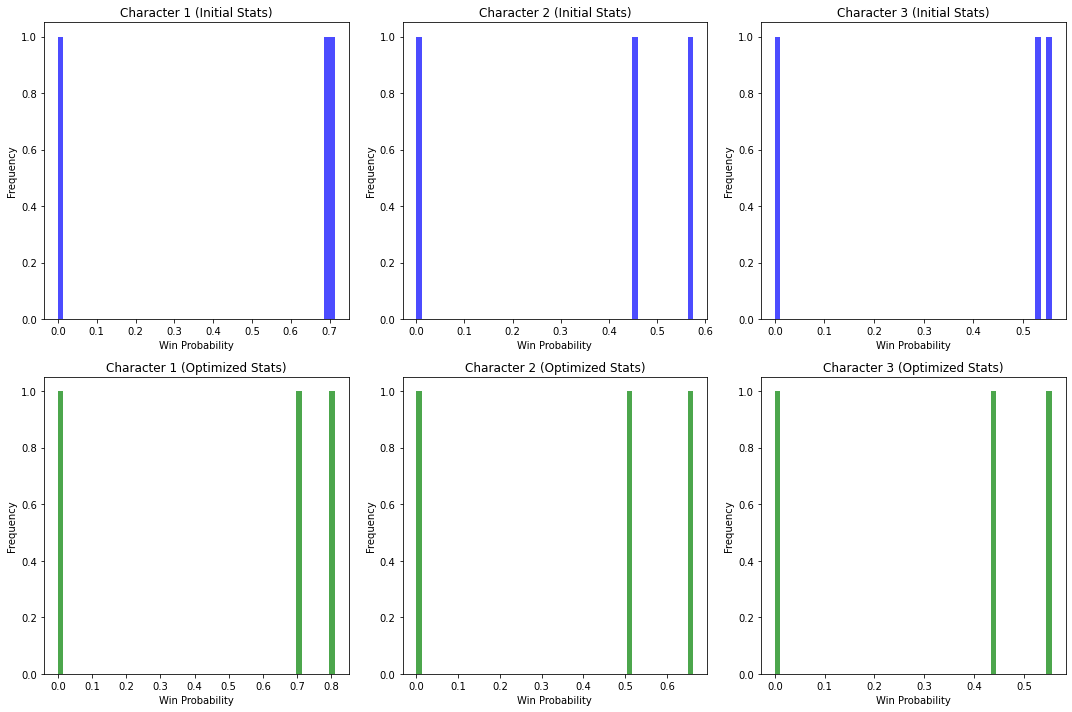

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initial stats for characters: attack, defense, health, speed
attack = np.array([10, 12, 8])
defense = np.array([8, 6, 9])
health = np.array([100, 90, 110])
speed = np.array([7, 6, 8])


# Optimized stats after optimization
optimized_attack = np.array([11, 13, 9])
optimized_defense = np.array([9, 7, 10])
optimized_health = np.array([105, 95, 115])
optimized_speed = np.array([8, 7, 9])

# Battle simulation function with randomness
def battle_prob(character1, character2):
    """
    A simplified formula to calculate the probability of character1 winning
    against character2 based on their attributes, with randomness.
    """
    attack1, defense1, health1, speed1 = character1
    attack2, defense2, health2, speed2 = character2
    
    # Simplified formula considering attack vs defense, and speed as a factor
    attack_diff = attack1 - attack2 + (speed1 - speed2) * 0.5
    defense_diff = defense1 - defense2
    health_factor = health1 / (health1 + health2)
    
    # Base probability function
    prob = 1 / (1 + np.exp(-(attack_diff + defense_diff + health_factor)))
    
    # Add randomness (simulate luck or chance)
    randomness = np.random.uniform(-0.1, 0.1)  # Randomness in the range [-0.1, 0.1]
    prob = np.clip(prob + randomness, 0, 1)  # Ensure probability stays between 0 and 1
    
    return prob

# Simulate battles using binomial distribution and calculate win probability
def simulate_battles_binomial(n_battles, characters_initial, characters_optimized):
    n_chars = len(characters_initial)
    initial_win_counts = np.zeros((n_chars, n_chars))  # Count of wins for initial stats
    optimized_win_counts = np.zeros((n_chars, n_chars))  # Count of wins for optimized stats
    
    # Run battles for initial and optimized stats
    for i in range(n_chars):
        for j in range(n_chars):
            if i != j:  # Only run battles between different characters
                # Battle probability for initial stats
                initial_prob = battle_prob(characters_initial[i], characters_initial[j])
                # Simulate n_battles using a binomial distribution
                initial_wins = np.random.binomial(n_battles, initial_prob)
                initial_win_counts[i, j] = initial_wins
                
                # Battle probability for optimized stats
                optimized_prob = battle_prob(characters_optimized[i], characters_optimized[j])
                # Simulate n_battles using a binomial distribution
                optimized_wins = np.random.binomial(n_battles, optimized_prob)
                optimized_win_counts[i, j] = optimized_wins
    
    return initial_win_counts, optimized_win_counts

# Characters: each character's stats (attack, defense, health, speed)
characters_initial = np.vstack([attack, defense, health, speed]).T
characters_optimized = np.vstack([optimized_attack, optimized_defense, optimized_health, optimized_speed]).T

# Simulate 10,000 battles for each pair using binomial distribution
n_battles = 10000
initial_win_counts, optimized_win_counts = simulate_battles_binomial(n_battles, characters_initial, characters_optimized)

# Calculate win probabilities from counts
initial_probs = initial_win_counts / n_battles
optimized_probs = optimized_win_counts / n_battles

# Plot histograms for win probabilities
n_chars = len(attack)
plt.figure(figsize=(15, 10))

# Plot initial stats win probabilities
for i in range(n_chars):
    plt.subplot(2, n_chars, i + 1)
    # Flatten the 2D probabilities array for each character pair and plot the histogram
    plt.hist(initial_probs[i, :], bins=50, color='blue', alpha=0.7, label=f'Character {i+1}')
    plt.title(f'Character {i+1} (Initial Stats)')
    plt.xlabel('Win Probability')
    plt.ylabel('Frequency')

# Plot optimized stats win probabilities
for i in range(n_chars):
    plt.subplot(2, n_chars, n_chars + i + 1)
    # Flatten the 2D probabilities array for each character pair and plot the histogram
    plt.hist(optimized_probs[i, :], bins=50, color='green', alpha=0.7, label=f'Character {i+1}')
    plt.title(f'Character {i+1} (Optimized Stats)')
    plt.xlabel('Win Probability')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
